<a href="https://colab.research.google.com/github/Lape2/Insightful-Analytics-Hub/blob/main/Food_Recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Patterns in FDA Food Recalls: A Machine Learning Approach**

# Olapeju Esuola, MSBA
# University of Louisville
# May 01, 2025

## **Summary**
**Goal:** Explore FDA recall data, identify patterns, and predict recall outcomes.

**Dataset:** FDA food recalls dataset with product descriptions, recall reasons, companies, and recall status.

**Core Problem:** Understand what drives recall termination and cluster similar recall reasons.

**Main Steps:**

Data cleaning and preparation

Exploratory data analysis (EDA)

Feature engineering (e.g., description length, encoding text)

Clustering on recall reason descriptions

Forecasting recall volume

Predicting recall termination status

**Key Finding:** Company name and year are top predictors of whether a recall will be terminated.

### **Code Explanation**
**Data cleaning:** Handled missing values, converted date formats, extracted year/month, grouped reasons.

**EDA:** Visualized top recall reasons, product types, and recall trends over time; explored active vs. terminated patterns.

**Feature engineering:** Encoded categorical fields, created description length, grouped rare categories.

**Model training:** Used KMeans for clustering, Prophet for time-series forecasting, and Random Forest for classification.

**Evaluation:** Reported precision, recall, f1-score; identified feature importance.


### **Insights**
Listeria, Salmonella, and allergens dominate recall reasons.

Recall counts are increasing over time.

Company name is a strong predictor of recall termination.

Clusters reveal distinct patterns in recall reasons.

### **Recommendations**
Use advanced text models (like TF-IDF or BERT) for recall
descriptions; apply oversampling to balance classes.




In [2]:
!pip install prophet

In [3]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from prophet import Prophet
import plotly.express as px

In [5]:
# 3. Upload Excel File in Colab
from google.colab import files
uploaded = files.upload()




Saving recalls-market-withdrawals-safety-alerts.xlsx to recalls-market-withdrawals-safety-alerts (1).xlsx


In [7]:
import io
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]), engine='openpyxl')

In [8]:
# 4. Data Cleaning & Feature Engineering
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Year'] = df['Date'].dt.to_period('M').astype(str)

def group_reason(text):
    text = str(text).lower()
    if "salmonella" in text:
        return "Salmonella"
    elif "listeria" in text:
        return "Listeria"
    elif "allergen" in text or "undeclared" in text:
        return "Allergen"
    elif "lead" in text or "contaminant" in text:
        return "Contaminant"
    else:
        return "Other"

df['Recall_Category'] = df['Recall-Reason-Description'].apply(group_reason)
df['Desc_Length'] = df['Product-Description'].apply(lambda x: len(str(x).split()))

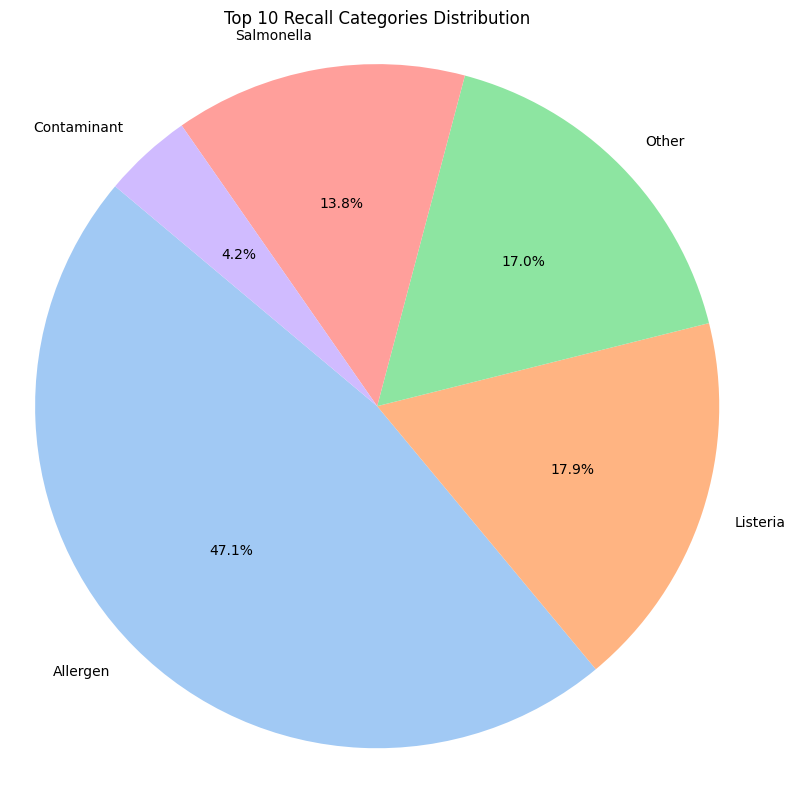

In [15]:
# Pie Chart of Top Recall Categories
category_counts = df['Recall_Category'].value_counts().nlargest(10)
plt.figure(figsize=(8,8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.axis('equal')
plt.title("Top 10 Recall Categories Distribution")
plt.tight_layout()
plt.show()


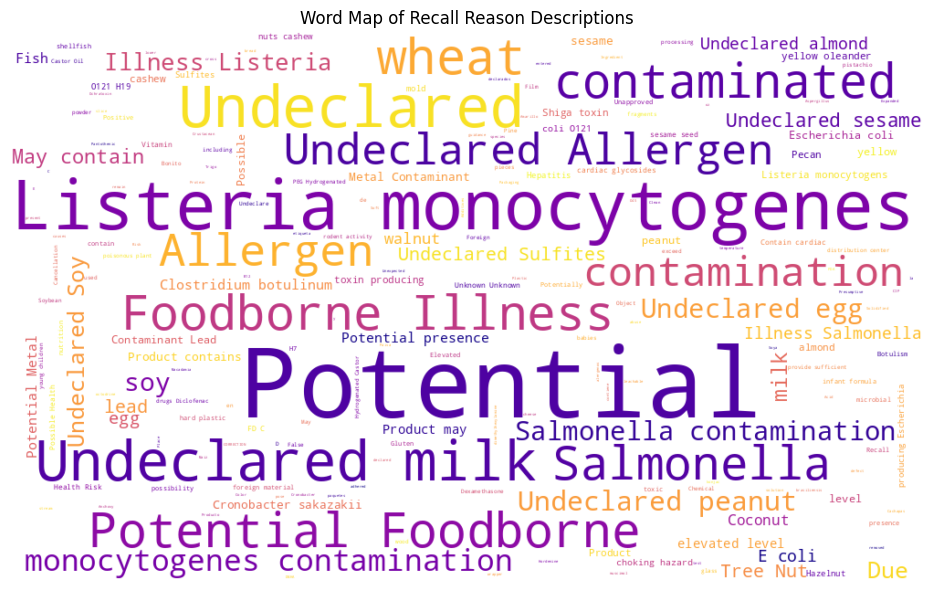

In [18]:

# Word Map of Recall Reason Descriptions
from wordcloud import WordCloud

text_data = ' '.join(df['Recall-Reason-Description'].dropna().astype(str).tolist())
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='plasma').generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Map of Recall Reason Descriptions")
plt.tight_layout()
plt.show()

<ipython-input-17-4bfac0973689>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




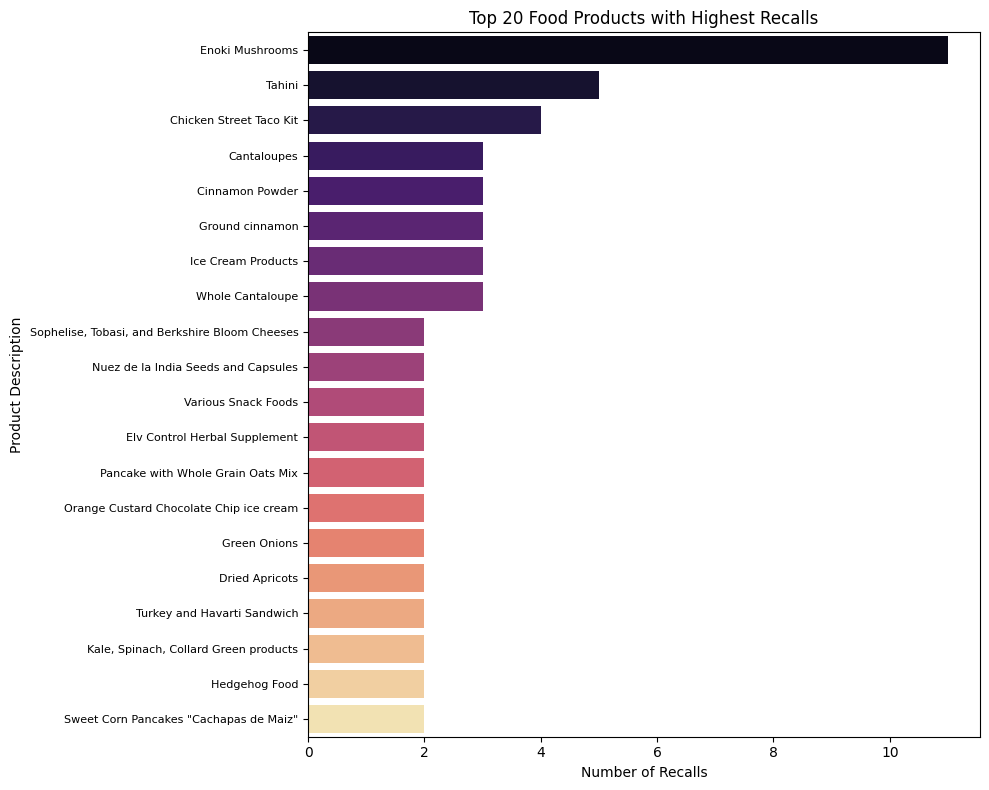

In [17]:
# Top 20 Food Products (Product-Description)
product_counts = df['Product-Description'].value_counts().nlargest(20)
plt.figure(figsize=(10,8))
sns.barplot(x=product_counts.values, y=product_counts.index, palette='magma')
plt.title("Top 20 Food Products with Highest Recalls")
plt.yticks(fontsize=8)
plt.xlabel("Number of Recalls")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()

In [28]:
# Get top 20 products by recall count
top_products = df['Product-Description'].value_counts().nlargest(20).index

# Filter data for these products
top_df = df[df['Product-Description'].isin(top_products)][['Product-Description', 'Recall-Reason-Description']]

# Count the most common recall reason per product
top_summary = top_df.groupby('Product-Description')['Recall-Reason-Description'].agg(lambda x: x.value_counts().index[0]).reset_index()
top_summary.rename(columns={'Recall-Reason-Description': 'Top Recall Reason'}, inplace=True)

# Display as styled table
top_summary_styled = top_summary.style.set_caption("Top 20 Product Descriptions and Their Most Common Recall Reasons").set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#a6c8ff'), ('color', 'black')]},
    {'selector': 'td', 'props': [('background-color', '#f7a6e0'), ('color', 'black')]}
])

top_summary_styled

,Product-Description,Top Recall Reason
0,Cantaloupes,"Potential Foodborne Illness, Salmonella"
1,Chicken Street Taco Kit,Potential Listeria monocytogenes contamination.
2,Cinnamon Powder,Potential Metal Contaminant - Lead
3,Dried Apricots,Undeclared Sulfites
4,Elv Control Herbal Supplement,Product contains yellow oleander.
5,Enoki Mushrooms,Listeria monocytogenes
6,Green Onions,Recall Cancellation Due to False Positive
7,Ground cinnamon,Potential Metal Contaminant - Lead
8,Hedgehog Food,Due to potential Salmonella contamination
9,Ice Cream Products,Potential Foodborne Illness


In [29]:
# Get top 20 products by recall count
top_products = df['Product-Description'].value_counts().nlargest(20).index

# Filter data for these products
top_df = df[df['Product-Description'].isin(top_products)][['Product-Description', 'Recall-Reason-Description']]

# Drop duplicates
top_df = top_df.drop_duplicates().reset_index(drop=True)

# Display as styled table
top_df_styled = top_df.style.set_caption("Top 20 Product Descriptions with Their Recall Reasons").set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#a6c8ff'), ('color', 'black')]},
    {'selector': 'td', 'props': [('background-color', '#f7a6e0'), ('color', 'black')]}
])

top_df_styled

,Product-Description,Recall-Reason-Description
0,Enoki Mushrooms,Listeria monocytogenes contamination
1,Tahini,Salmonella
2,Enoki Mushrooms,Potential to be contaminated with Listeria Monocytogenes
3,Various Snack Foods,"Undeclared milk, wheat, soy, tree nuts"
4,Enoki Mushrooms,Listeria monocytogenes
5,Turkey and Havarti Sandwich,Product may contain undeclared sesame in bread
6,Turkey and Havarti Sandwich,"Undeclared allergen, sesame"
7,"Sophelise, Tobasi, and Berkshire Bloom Cheeses",Potential contamination with Listeria monocytogenes
8,Dried Apricots,Undeclared Sulfites
9,Ice Cream Products,Potential Foodborne Illness


In [30]:
# Top 5 Recall Reasons for Each Year

top5_per_year = (df.groupby(['Year', 'Recall-Reason-Description'])
                   .size()
                   .reset_index(name='Count')
                   .sort_values(['Year', 'Count'], ascending=[True, False]))

# Get top 5 per year
top5_per_year = top5_per_year.groupby('Year').head(5).reset_index(drop=True)

# Display as styled table
top5_styled = top5_per_year.style.set_caption("Top 5 Recall Reasons for Each Year").set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#a6c8ff'), ('color', 'black')]},
    {'selector': 'td', 'props': [('background-color', '#f7a6e0'), ('color', 'black')]}
])

top5_styled

,Year,Recall-Reason-Description,Count
0,2017,Potential mold contamination - Talaromyces penicillium,1
1,2018,Unknown,6
2,2018,Salmonella,1
3,2019,Due to Unexpected Solidified Ingredient,1
4,2019,E. coli O26,1
5,2019,E.coli,1
6,2019,Has the potential to be contaminated with E. coli: O121 and O103,1
7,2019,Possible Hepatitis A Contamination,1
8,2020,Potential to be contaminated with Listeria monocytogenes,2
9,2020,Potential Contamination by Salmonella,1


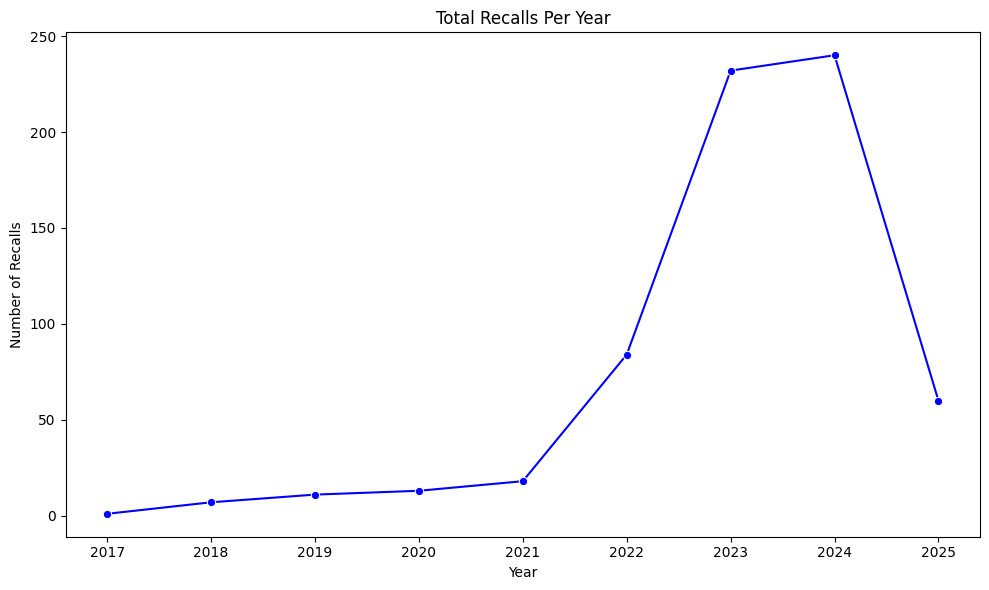

In [32]:
# Line Chart of Total Recalls Per Year
total_recalls_per_year = df.groupby('Year').size().reset_index(name='Total Recalls')
plt.figure(figsize=(10,6))
sns.lineplot(data=total_recalls_per_year, x='Year', y='Total Recalls', marker='o', color='blue')
plt.title('Total Recalls Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Recalls')
plt.tight_layout()
plt.show()

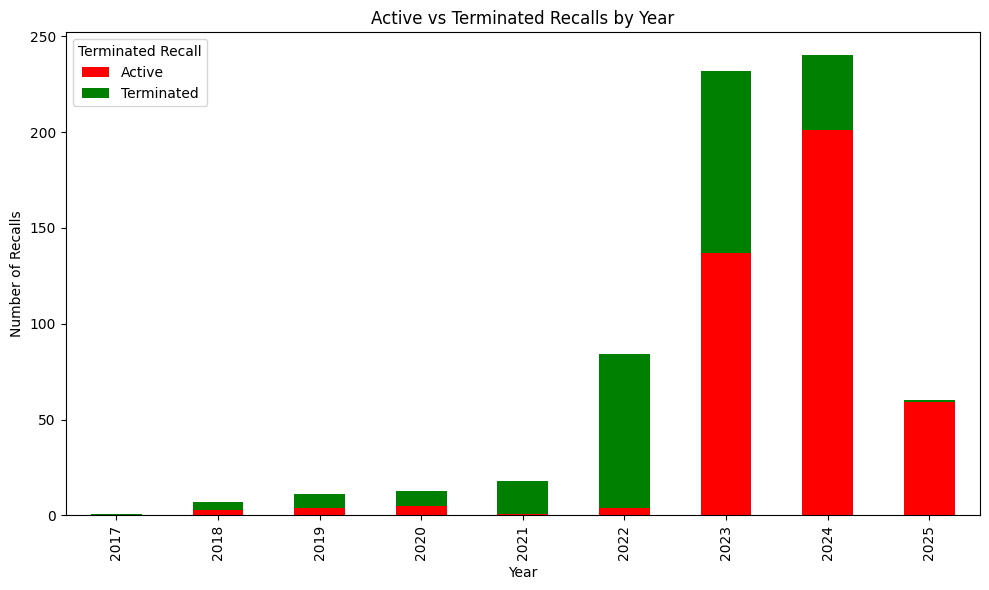

In [24]:
# 5. Terminated vs Active Recalls per Year
status_by_year = df.groupby(['Year', 'Terminated Recall']).size().unstack(fill_value=0)
status_by_year.plot(kind='bar', stacked=True, figsize=(10,6), color=['red', 'green'])
plt.title("Active vs Terminated Recalls by Year")
plt.ylabel("Number of Recalls")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


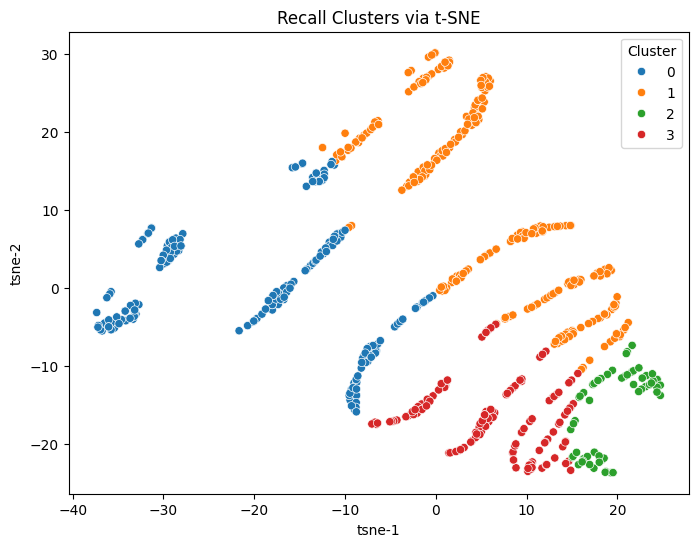

In [34]:
# 6. Clustering Analysis
features = df[['Recall-Reason-Description']].fillna("Unknown")
encoded = features.apply(LabelEncoder().fit_transform)
encoded['Desc_Length'] = df['Desc_Length']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded)

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
df['tsne-1'] = tsne_result[:,0]
df['tsne-2'] = tsne_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='tsne-1', y='tsne-2', hue='Cluster', palette='tab10')
plt.title("Recall Clusters via t-SNE")
plt.show()

In [38]:
cluster_summary = df.groupby('Cluster')['Recall-Reason-Description'].apply(lambda x: x.value_counts().head(5))
print("\nTop Recall Reasons per Cluster:")
print(cluster_summary)


Top Recall Reasons per Cluster:
Cluster                                                          
0        Listeria monocytogenes                                      19
         Potential Listeria monocytogenes contamination               9
         Potential to be contaminated with Salmonella                 9
         Potential Metal Contaminant - Lead                           8
         Potential Foodborne Illness/Salmonella                       6
1        Undeclared milk                                             22
         Salmonella                                                  11
         Undeclared Milk                                             10
         Undeclared peanuts                                           8
         Undeclared egg                                               7
2        Undeclared milk                                              4
         Potential to be contaminated with Listeria monocytogenes     3
         Salmonella                  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcg60dff6/xa9y43bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcg60dff6/qhdf6nyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40319', 'data', 'file=/tmp/tmpcg60dff6/xa9y43bg.json', 'init=/tmp/tmpcg60dff6/qhdf6nyj.json', 'output', 'file=/tmp/tmpcg60dff6/prophet_modelvdtak7q3/prophet_model-20250430232217.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

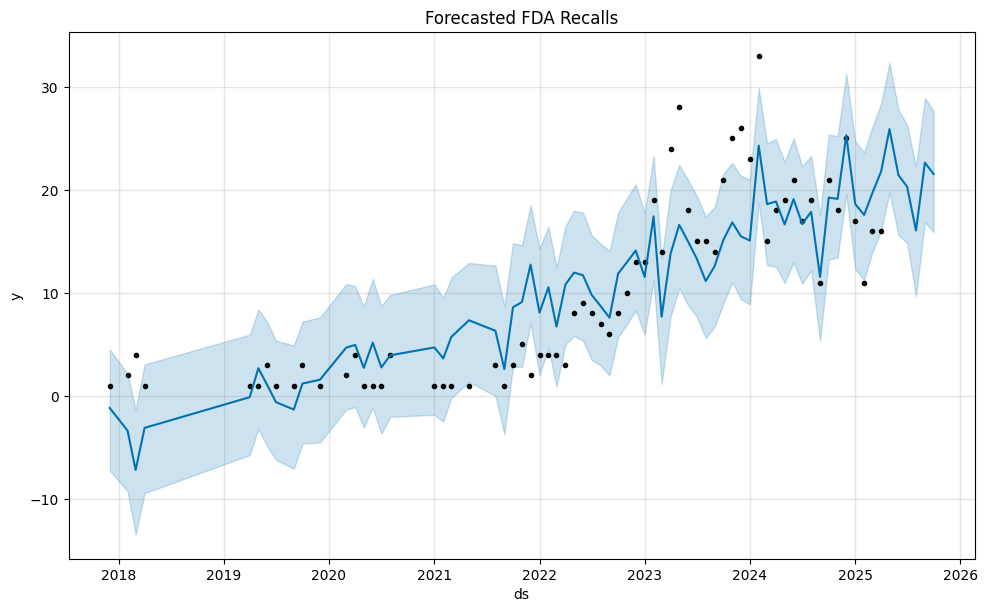

In [11]:
# 7. Time Series Forecasting of Total Recalls
recalls_per_month = df.groupby('Month_Year').size().reset_index(name='y')
recalls_per_month.rename(columns={'Month_Year': 'ds'}, inplace=True)
recalls_per_month['ds'] = pd.to_datetime(recalls_per_month['ds'])

model = Prophet()
model.fit(recalls_per_month)

future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title("Forecasted FDA Recalls")
plt.show()

### Explanation of Forecast Plot

The forecast plot shows the historical and predicted number of FDA recalls over time.

- The horizontal axis (x-axis) is time, from 2018 to 2026.
- The vertical axis (y-axis) is the number of recalls.
- The **blue line** represents the predicted trend of recalls over time from the forecasting model.
- The **black dots** represent the actual historical data points — the real recorded number of recalls.
- The **blue shaded area** around the blue line is the uncertainty interval (confidence interval), showing the range where future recall numbers are likely to fall with a certain level of confidence.

### Insights:
- There is an overall upward trend, meaning FDA recalls are expected to increase over time.
- The model predicts higher recall counts especially after 2023.
- The wide blue shaded band in later years reflects greater uncertainty as we forecast further into the future.


In [12]:
# 8. Predict Recall Termination Status
clf_features = df[['Recall_Category', 'Product-Types', 'Company-Name', 'Desc_Length', 'Year', 'Month']].fillna("Unknown")
clf_encoded = clf_features.apply(LabelEncoder().fit_transform)

y = df['Terminated Recall'].apply(lambda x: 1 if x == 'Terminated' else 0)
X_train, X_test, y_train, y_test = train_test_split(clf_encoded, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\nClassification Report for Terminated Recall Prediction:\n")
print(classification_report(y_test, y_pred))


Classification Report for Terminated Recall Prediction:

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        76
           1       0.62      0.53      0.57        58

    accuracy                           0.66       134
   macro avg       0.65      0.64      0.64       134
weighted avg       0.65      0.66      0.65       134



# Insights:
- There’s an overall upward trend, suggesting recalls are expected to increase.
- The widening blue band toward the future shows increasing uncertainty.


 Classification Report Interpretation (Terminated Recall Prediction):
- **Precision** measures how many predicted positive cases were actually positive.
- **Recall** measures how many actual positive cases were correctly predicted.
- **F1-score** balances precision and recall.

 Breakdown:
 - Class 0 (Active recalls): precision 0.68, recall 0.75, f1-score 0.71
 - Class 1 (Terminated recalls): precision 0.62, recall 0.53, f1-score 0.57
- **Overall accuracy:** 66%
- **Macro average:** average across classes, treating all equally.
- **Weighted average:** accounts for class imbalance.

### Summary and Suggestions:
-  The model performs slightly better at predicting active recalls than terminated ones, with room to improve recall on terminated recalls.
- A 66% accuracy is moderate but can be improved.

Suggestions to improve performance:
- Add more features (e.g., company name, product type, description length)
- Try more advanced models (e.g., Gradient Boosting, XGBoost)
- Perform hyperparameter tuning on the RandomForestClassifier
- Balance the dataset using oversampling or undersampling techniques
- Apply text vectorization (like TF-IDF) on recall reason descriptions instead of simple label encoding.

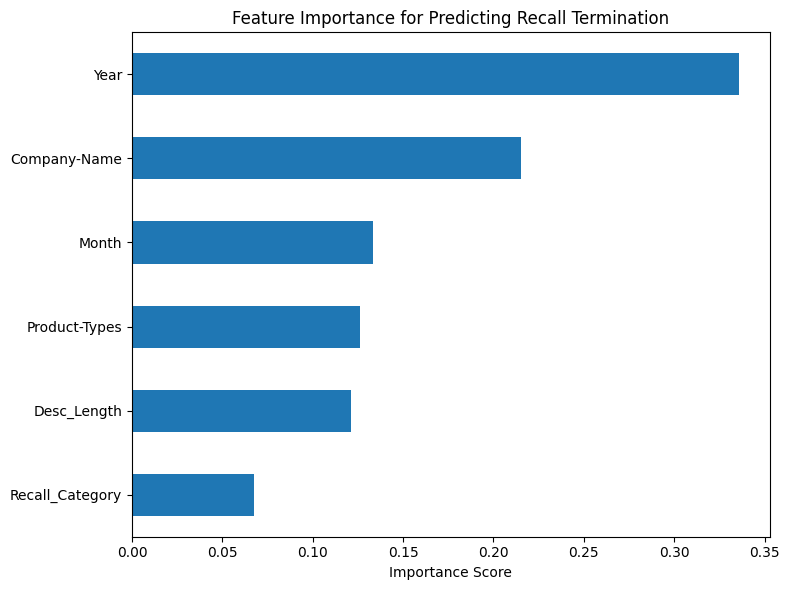

In [13]:
# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=clf_encoded.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance for Predicting Recall Termination")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Feature Importance Insight:
The top features influencing whether a recall is predicted as terminated are **Year** and **Company Name**. This suggests that the company involved plays a critical role in determining the likelihood of a recall being terminated, possibly reflecting differences in company practices, resources, or regulatory responses over time.











